In [1]:
from numba import jit
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier as RFE
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from joblib import Parallel, delayed
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import tensorflow as tf

In [3]:
from sklearn.model_selection import ParameterGrid

In [2]:
pd.set_option('display.max_columns', None)


In [4]:
# Load Data
df = pd.read_csv("https://media.githubusercontent.com/media/DimasRamadhanX/Python-data-101/refs/heads/main/PAP%20C/df_cleaned.csv")

In [5]:
df=df.drop(['Date Rptd','DATE OCC','Crm Cd Desc','Mocodes','Vict Age','Weapon Used Cd','LOCATION','Status Desc','Crm Cd 1','Crm Cd 2','Crm Cd 3','Crm Cd 4','Premis Cd'],axis=1)

In [6]:
df.head()

,TIME OCC,Crm Cd,Premis Desc,Weapon Desc,Status,LAT,LON,hour,day_name,month_name,Vict Sex_F,Vict Sex_M,Vict Sex_X,Vict Descent_A,Vict Descent_B,Vict Descent_C,Vict Descent_D,Vict Descent_F,Vict Descent_G,Vict Descent_H,Vict Descent_I,Vict Descent_J,Vict Descent_K,Vict Descent_L,Vict Descent_O,Vict Descent_P,Vict Descent_S,Vict Descent_U,Vict Descent_V,Vict Descent_W,Vict Descent_X,Vict Descent_Z,AgeStd,season,night-day,Region
0,2130,510,STREET,No Weapon,AA,34.0375,-118.3506,21,Sunday,March,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.329626,Winter,Night,Other Region
1,1800,330,BUS STOP/LAYOVER (ALSO QUERY 124),No Weapon,IC,34.0444,-118.2628,18,Saturday,February,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.812370,Winter,Night,Downtown Los Angeles
2,1700,480,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",No Weapon,IC,34.0210,-118.3002,17,Wednesday,November,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.463713,Fall,Day,Other Region
3,2037,343,CLOTHING STORE,No Weapon,IC,34.1576,-118.4387,20,Tuesday,March,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.463713,Winter,Night,San Fernando Valley
4,1200,354,SIDEWALK,No Weapon,IC,34.0944,-118.3277,12,Monday,August,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.053543,Summer,Day,Other Region


In [7]:
class_counts = df['Crm Cd'].value_counts()
class_counts


Crm Cd
510    107703
624     73671
330     60486
354     59770
740     58764
        ...  
884         4
906         4
445         4
926         1
453         1
Name: count, Length: 140, dtype: int64

In [8]:
object_cols = df.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
for col in object_cols:
    df[col] = label_encoder.fit_transform(df[col]).astype('int16')

In [9]:
# Inisialisasi OneHotEncoder
# Assume df is your original DataFrame
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit and transform the specified columns
encoded_features = encoder.fit_transform(df[['day_name', 'month_name', 'Status', 'season', 'Region']])

# Create DataFrame with encoded features
encoded_df = pd.DataFrame(
    encoded_features,
    columns=encoder.get_feature_names_out(['day_name', 'month_name', 'Status', 'season', 'Region'])
)

# Convert all encoded columns to int8
encoded_df = encoded_df.astype('int8')

# Combine with original DataFrame and drop original columns
df = pd.concat(
    [df.reset_index(drop=True), encoded_df],
    axis=1
).drop(columns=['day_name', 'month_name', 'Status', 'season', 'Region'])


In [10]:
df.fillna(0, inplace=True)


In [11]:
df['hour']=df['hour'].astype('int8')
df['TIME OCC']=df['TIME OCC'].astype('int16')
df['Crm Cd']=df['Crm Cd'].astype('int16')


In [12]:

for col in df.columns:
    if col.startswith("Vict"):
        df[col] = df[col].astype('int8')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 964311 entries, 0 to 964310
Data columns (total 63 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TIME OCC        964311 non-null  int16  
 1   Crm Cd          964311 non-null  int16  
 2   Premis Desc     964311 non-null  int16  
 3   Weapon Desc     964311 non-null  int16  
 4   LAT             964311 non-null  float64
 5   LON             964311 non-null  float64
 6   hour            964311 non-null  int8   
 7   Vict Sex_F      964311 non-null  int8   
 8   Vict Sex_M      964311 non-null  int8   
 9   Vict Sex_X      964311 non-null  int8   
 10  Vict Descent_A  964311 non-null  int8   
 11  Vict Descent_B  964311 non-null  int8   
 12  Vict Descent_C  964311 non-null  int8   
 13  Vict Descent_D  964311 non-null  int8   
 14  Vict Descent_F  964311 non-null  int8   
 15  Vict Descent_G  964311 non-null  int8   
 16  Vict Descent_H  964311 non-null  int8   
 17  Vict Desce

In [14]:
df['Crm Cd'].value_counts()

Crm Cd
510    107703
624     73671
330     60486
354     59770
740     58764
        ...  
884         4
906         4
445         4
926         1
453         1
Name: count, Length: 140, dtype: int64

<Axes: >

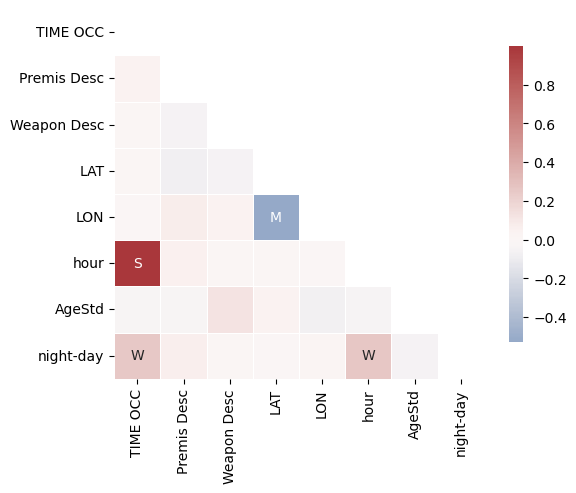

In [15]:
intdf=df[['TIME OCC', 'Premis Desc', 'Weapon Desc','LAT','LON','hour','AgeStd','night-day']]
corr = intdf.corr('spearman')
sns.heatmap(corr,
            annot = np.where(np.abs(corr)>0.75,'S', # correlation more than +/- 75% labelled as 'STRONG CORRELATION'
                      np.where(np.abs(corr)>0.5,'M', # correlation more than +/- 50% labelled as 'MEDIUM CORRELATION'
                           np.where(np.abs(corr)>0.25,'W',''))), # correlation more than +/- 25% labelled as 'WEAK CORRELATION'
            mask=np.triu(np.ones_like(corr, dtype=bool)),
            square=True,
            center=0,fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8}
            )

In [16]:
df.drop('TIME OCC',axis=1)

,Crm Cd,Premis Desc,Weapon Desc,LAT,LON,hour,Vict Sex_F,Vict Sex_M,Vict Sex_X,Vict Descent_A,Vict Descent_B,Vict Descent_C,Vict Descent_D,Vict Descent_F,Vict Descent_G,Vict Descent_H,Vict Descent_I,Vict Descent_J,Vict Descent_K,Vict Descent_L,Vict Descent_O,Vict Descent_P,Vict Descent_S,Vict Descent_U,Vict Descent_V,Vict Descent_W,Vict Descent_X,Vict Descent_Z,AgeStd,night-day,day_name_1,day_name_2,day_name_3,day_name_4,day_name_5,day_name_6,month_name_1,month_name_2,month_name_3,month_name_4,month_name_5,month_name_6,month_name_7,month_name_8,month_name_9,month_name_10,month_name_11,Status_1,Status_2,Status_3,Status_4,Status_5,season_1,season_2,season_3,season_4,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6
0,510,266,42,34.0375,-118.3506,21,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,-1.329626,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,330,29,42,34.0444,-118.2628,18,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.812370,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,480,207,42,34.0210,-118.3002,17,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.463713,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,343,40,42,34.1576,-118.4387,20,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,-0.463713,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
4,354,254,42,34.0944,-118.3277,12,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.053543,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964306,510,266,42,34.0362,-118.3284,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.329626,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
964307,745,97,76,34.0685,-118.2460,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.329626,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
964308,888,158,42,34.2500,-118.5990,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.329626,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
964309,230,254,64,34.0215,-118.2868,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.860581,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


In [17]:
class_counts = df['Crm Cd'].value_counts()

# Pilih kelas-kelas yang memiliki jumlah sampel di atas threshold
relevant_classes = class_counts[class_counts >= 10].index

# Filter dataset untuk hanya menyisakan kelas yang relevan
df = df[df['Crm Cd'].isin(relevant_classes)]


In [18]:
X = df.drop(columns=["Crm Cd"])
y = df["Crm Cd"]


In [19]:
# Menghitung jumlah sampel setiap kelas
class_counts = y.value_counts()

# Mengatur sampling_strategy untuk memastikan setidaknya 500 sampel per kelas
sampling_strategy = {int(label): int(min(count, 500)) for label, count in class_counts.items()}

# Inisialisasi dan terapkan RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X, y= undersampler.fit_resample(X, y)


In [18]:
pd.set_option('display.max_rows', None)
print(y.value_counts())

Crm Cd
110    500
480    500
761    500
753    500
745    500
740    500
668    500
664    500
662    500
661    500
121    500
649    500
648    500
647    500
627    500
626    500
625    500
624    500
623    500
522    500
520    500
762    500
763    500
810    500
890    500
946    500
940    500
930    500
910    500
903    500
902    500
901    500
900    500
888    500
812    500
886    500
860    500
850    500
845    500
821    500
820    500
815    500
813    500
510    500
956    500
230    500
352    500
421    500
420    500
410    500
331    500
210    500
310    500
437    500
251    500
354    500
440    500
320    500
341    500
442    500
237    500
236    500
235    500
343    500
350    500
231    500
220    500
330    500
928    476
250    470
441    468
755    467
822    467
922    445
932    376
434    338
666    320
951    318
122    315
814    273
438    269
943    259
622    239
920    231
933    200
433    178
439    176
670    142
806    136
805    135
660

In [20]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


In [21]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [22]:
selector = SelectKBest(score_func=f_classif, k=28)


In [23]:

X_train = selector.fit_transform(X_train, y_train)
X_test= selector.transform(X_test)

In [605]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 964200 entries, 0 to 964310
Data columns (total 63 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TIME OCC        964200 non-null  int16  
 1   Crm Cd          964200 non-null  int16  
 2   Premis Desc     964200 non-null  int16  
 3   Weapon Desc     964200 non-null  int16  
 4   LAT             964200 non-null  float64
 5   LON             964200 non-null  float64
 6   hour            964200 non-null  int8   
 7   Vict Sex_F      964200 non-null  float64
 8   Vict Sex_M      964200 non-null  float64
 9   Vict Sex_X      964200 non-null  float64
 10  Vict Descent_A  964200 non-null  float64
 11  Vict Descent_B  964200 non-null  float64
 12  Vict Descent_C  964200 non-null  float64
 13  Vict Descent_D  964200 non-null  float64
 14  Vict Descent_F  964200 non-null  float64
 15  Vict Descent_G  964200 non-null  float64
 16  Vict Descent_H  964200 non-null  float64
 17  Vict Descent_I 

In [33]:
def calculate_metrics(y_true, y_pred, y_pred_proba=None):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1': f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }
    
    if y_pred_proba is not None:
        try:
            # For multiclass ROC AUC
            lb = LabelBinarizer()
            y_true_bin = lb.fit_transform(y_true)
            if y_pred_proba.shape[1] == 2:  # Binary classification
                metrics['roc_auc'] = roc_auc_score(y_true_bin, y_pred_proba[:, 1])
            else:  # Multi-class
                metrics['roc_auc'] = roc_auc_score(
                    y_true_bin, 
                    y_pred_proba,
                    multi_class='ovr',
                    average='weighted'
                )
        except Exception as e:
            print(f"Warning: Could not calculate ROC AUC: {str(e)}")
            metrics['roc_auc'] = None
    
    return metrics


In [25]:
def run_cross_validation(model, X, y, skf):
    fold_metrics = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_fold_train, X_fold_val = X[train_idx], X[val_idx]
        y_fold_train, y_fold_val = y[train_idx], y[val_idx]
        
        # Scale the features
        scaler = StandardScaler()
        X_fold_train_scaled = scaler.fit_transform(X_fold_train)
        X_fold_val_scaled = scaler.transform(X_fold_val)
        
        # Train the model
        model.fit(X_fold_train_scaled, y_fold_train)
        
        # Make predictions
        y_pred = model.predict(X_fold_val_scaled)
        
        # Get prediction probabilities if the model supports it
        try:
            y_pred_proba = model.predict_proba(X_fold_val_scaled)
        except:
            y_pred_proba = None
        
        # Calculate metrics
        metrics = calculate_metrics(y_fold_val, y_pred, y_pred_proba)
        metrics['fold'] = fold
        fold_metrics.append(metrics)
    
    return pd.DataFrame(fold_metrics)

In [40]:
def run_knn_experiment(X_train, y_train, k_values=[3, 4, 5, 6, 7]):
    knn_results = {}
    
    for k in k_values:
        print(f"\nTraining KNN with k={k}")
        knn = KNeighborsClassifier(n_neighbors=k)
        metrics_df = run_cross_validation(knn, X_train, y_train, skf)
        
        print(f"\nResults for k={k}:")
        print(metrics_df.mean())
        knn_results[k] = metrics_df
    
    # Find best k based on mean f1 score
    best_k = max(k_values, key=lambda k: knn_results[k]['f1'].mean())
    return knn_results, best_k

In [41]:
def run_nb_experiment(X_train, y_train):
    print("\nTraining Naive Bayes")
    nb = GaussianNB()
    metrics_df = run_cross_validation(nb, X_train, y_train, skf)
    
    print("\nNaive Bayes Results:")
    print(metrics_df.mean())
    return metrics_df

In [42]:
def run_lr_experiment(X_train, y_train):
    print("\nTraining Logistic Regression")
    lr = LogisticRegression(max_iter=1000, multi_class='multinomial')
    metrics_df = run_cross_validation(lr, X_train, y_train, skf)
    
    print("\nLogistic Regression Results:")
    print(metrics_df.mean())
    return metrics_df


In [24]:

# 4. SVM Implementation
def run_svm_experiment(X_train, y_train, kernels=['linear', 'rbf'], C_values=[0.001, 0.01, 0.04]):
    svm_results = {}
    
    for kernel in kernels:
        for C in C_values:
            print(f"\nTraining SVM with kernel={kernel}, C={C}")
            svm = SVC(kernel=kernel, C=C, probability=True)
            metrics_df = run_cross_validation(svm, X_train, y_train, skf)
            
            print(f"\nResults for kernel={kernel}, C={C}:")
            print(metrics_df.mean())
            svm_results[(kernel, C)] = metrics_df
    
    # Find best combination based on mean f1 score
    best_params = max(svm_results.keys(), key=lambda params: svm_results[params]['f1'].mean())
    return svm_results, best_params

In [31]:
#5.  DST


def run_decision_tree_experiment(X_train, y_train, param_grid):
    dt_results = {}
    
    # Buat kombinasi dari parameter grid
    parameter_combinations = list(ParameterGrid(param_grid))
    
    for params in parameter_combinations:
        print(f"\nTraining Decision Tree with params: {params}")
        dt = DecisionTreeClassifier(**params)
        metrics_df = run_cross_validation(dt, X_train, y_train, skf)
        
        print(f"\nResults for params {params}:")
        print(metrics_df.mean())
        dt_results[tuple(params.items())] = metrics_df
    
    # Cari parameter terbaik berdasarkan rata-rata f1-score
    best_params = max(parameter_combinations, key=lambda p: dt_results[tuple(p.items())]['f1'].mean())
    return dt_results, best_params

In [581]:
def evaluate_final_model(model, X_train, X_test, y_train, y_test):
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Get prediction probabilities if the model supports it
    try:
        y_pred_proba = model.predict_proba(X_test_scaled)
    except:
        y_pred_proba = None
    
    # Calculate metrics
    return calculate_metrics(y_test, y_pred, y_pred_proba)


In [30]:

# Run experiments
print("Starting experiments...")


Starting experiments...


In [47]:
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
y_test_np  = np.array(y_test)
X_test_np  = np.array(X_test)

In [48]:


# KNN
print("\n=== KNN Experiments ===")
knn_results, best_k = run_knn_experiment(X_train_np, y_train_np)



=== KNN Experiments ===

Training KNN with k=3

Results for k=3:
accuracy     0.065739
precision    0.089946
recall       0.065739
f1           0.060850
roc_auc      0.563203
fold         3.000000
dtype: float64

Training KNN with k=4

Results for k=4:
accuracy     0.064760
precision    0.084431
recall       0.064760
f1           0.059352
roc_auc      0.572446
fold         3.000000
dtype: float64

Training KNN with k=5

Results for k=5:
accuracy     0.064997
precision    0.083507
recall       0.064997
f1           0.059778
roc_auc      0.579542
fold         3.000000
dtype: float64

Training KNN with k=6

Results for k=6:
accuracy     0.064693
precision    0.080701
recall       0.064693
f1           0.059618
roc_auc      0.586135
fold         3.000000
dtype: float64

Training KNN with k=7

Results for k=7:
accuracy     0.064288
precision    0.078987
recall       0.064288
f1           0.059743
roc_auc      0.591235
fold         3.000000
dtype: float64


In [49]:
print("\n=== Final Test Set Evaluation ===")

# Best KNN
best_knn = KNeighborsClassifier(n_neighbors=best_k)
knn_test_metrics = evaluate_final_model(best_knn, X_train_np, X_test_np, y_train_np, y_test_np)
print(f"\nBest KNN (k={best_k}) Test Results:")
print(pd.Series(knn_test_metrics))



=== Final Test Set Evaluation ===

Best KNN (k=3) Test Results:
accuracy     0.068458
precision    0.094780
recall       0.068458
f1           0.065743
roc_auc      0.567444
dtype: float64


In [50]:
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
y_test_np  = np.array(y_test)
X_test_np  = np.array(X_test)

In [51]:

# Naive Bayes
print("\n=== Naive Bayes Experiments ===")
nb_results = run_nb_experiment(X_train_np, y_train_np)



=== Naive Bayes Experiments ===

Training Naive Bayes

Naive Bayes Results:
accuracy     0.001823
precision    0.904966
recall       0.001823
f1           0.000915
roc_auc      0.668149
fold         3.000000
dtype: float64


In [52]:

# Naive Bayes
nb = GaussianNB()
nb_test_metrics = evaluate_final_model(nb, X_train_np, X_test_np, y_train_np, y_test_np)
print("\nNaive Bayes Test Results:")
print(pd.Series(nb_test_metrics))



Naive Bayes Test Results:
accuracy     0.001339
precision    0.905119
recall       0.001339
f1           0.000788
roc_auc      0.702213
dtype: float64


In [53]:
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
y_test_np  = np.array(y_test)
X_test_np  = np.array(X_test)

In [54]:

# Logistic Regression
print("\n=== Logistic Regression Experiments ===")
lr_results = run_lr_experiment(X_train_np, y_train_np)



=== Logistic Regression Experiments ===

Training Logistic Regression


c:\Users\luxha\anaconda3\envs\rapids\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\luxha\anaconda3\envs\rapids\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\luxha\anaconda3\envs\rapids\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\luxha\anaconda3\envs\rapids\lib\site-packages\sklearn\linear_model\_logistic.py:1247: Futur


Logistic Regression Results:
accuracy     0.120505
precision    0.141920
recall       0.120505
f1           0.091452
roc_auc      0.807844
fold         3.000000
dtype: float64


In [55]:

# Logistic Regression
lr = LogisticRegression(max_iter=1000, multi_class='multinomial')
lr_test_metrics = evaluate_final_model(lr, X_train_np, X_test_np, y_train_np, y_test_np)
print("\nLogistic Regression Test Results:")
print(pd.Series(lr_test_metrics))

c:\Users\luxha\anaconda3\envs\rapids\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression Test Results:
accuracy     0.121790
precision    0.135841
recall       0.121790
f1           0.092942
roc_auc      0.809247
dtype: float64


In [56]:
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
y_test_np  = np.array(y_test)
X_test_np  = np.array(X_test)

In [27]:

# SVM
print("\n=== SVM Experiments ===")
svm_results, best_svm_params = run_svm_experiment(X_train_np, y_train_np)



=== SVM Experiments ===

Training SVM with kernel=linear, C=0.001

Results for kernel=linear, C=0.001:
accuracy     0.086167
precision    0.276434
recall       0.086167
f1           0.057067
roc_auc      0.803457
fold         3.000000
dtype: float64

Training SVM with kernel=linear, C=0.01

Results for kernel=linear, C=0.01:
accuracy     0.118817
precision    0.222301
recall       0.118817
f1           0.088552
roc_auc      0.821574
fold         3.000000
dtype: float64

Training SVM with kernel=linear, C=0.04

Results for kernel=linear, C=0.04:
accuracy     0.128744
precision    0.206247
recall       0.128744
f1           0.098323
roc_auc      0.826607
fold         3.000000
dtype: float64

Training SVM with kernel=rbf, C=0.001

Results for kernel=rbf, C=0.001:
accuracy     0.081271
precision    0.279513
recall       0.081271
f1           0.059888
roc_auc      0.791724
fold         3.000000
dtype: float64

Training SVM with kernel=rbf, C=0.01

Results for kernel=rbf, C=0.01:
accuracy  

In [ ]:

# Best SVM
kernel, C = best_svm_params
best_svm = SVC(kernel=kernel, C=C, probability=True)
print(best_svm_params)


In [60]:
#saya ulang lagi karena best SVM awal tidak sengaja tersntuh yang mengharuskan saya melatih dan memrediksi SVC dengan parameter terbaik
print(f"\nTraining SVM with kernel={kernel}, C={C}")
svm = SVC(kernel=kernel, C=C, probability=True)
metrics_df = run_cross_validation(svm, X_train_np, y_train_np, skf)
            
print(f"\nResults for kernel={kernel}, C={C}:")
print(metrics_df.mean())


Training SVM with kernel=linear, C=0.04

Results for kernel=linear, C=0.04:
accuracy     0.128744
precision    0.206247
recall       0.128744
f1           0.098323
roc_auc      0.826580
fold         3.000000
dtype: float64


In [61]:

svm_test_metrics = evaluate_final_model(best_svm, X_train_np, X_test_np, y_train_np, y_test_np)
print(f"\nBest SVM (kernel={kernel}, C={C}) Test Results:")
print(pd.Series(svm_test_metrics))



Best SVM (kernel=linear, C=0.04) Test Results:
accuracy     0.128565
precision    0.209660
recall       0.128565
f1           0.098737
roc_auc      0.828337
dtype: float64


In [29]:
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
y_test_np  = np.array(y_test)
X_test_np  = np.array(X_test)

In [645]:
param_grid = {
    'max_depth': [48,192],
    'min_samples_split': [40, 80],
    'min_samples_leaf': [40, 80],
    'max_features': [ 'sqrt', 'log2'],
    'max_leaf_nodes': [40, 80],
    'criterion': ['gini', 'entropy']
}

In [646]:
# DST
print("\n=== DST Experiments ===")
dst_results, best_dst = run_decision_tree_experiment(X_train_np, y_train_np, param_grid)


=== DST Experiments ===

Training Decision Tree with params: {'criterion': 'gini', 'max_depth': 48, 'max_features': 'sqrt', 'max_leaf_nodes': 40, 'min_samples_leaf': 40, 'min_samples_split': 40}

Results for params {'criterion': 'gini', 'max_depth': 48, 'max_features': 'sqrt', 'max_leaf_nodes': 40, 'min_samples_leaf': 40, 'min_samples_split': 40}:
accuracy    0.06503042
precision   0.73125511
recall      0.06503042
f1          0.03374675
roc_auc     0.74547104
fold        3.00000000
dtype: float64

Training Decision Tree with params: {'criterion': 'gini', 'max_depth': 48, 'max_features': 'sqrt', 'max_leaf_nodes': 40, 'min_samples_leaf': 40, 'min_samples_split': 80}

Results for params {'criterion': 'gini', 'max_depth': 48, 'max_features': 'sqrt', 'max_leaf_nodes': 40, 'min_samples_leaf': 40, 'min_samples_split': 80}:
accuracy    0.06317281
precision   0.73299568
recall      0.06317281
f1          0.03241038
roc_auc     0.74506086
fold        3.00000000
dtype: float64

Training Decisio

KeyboardInterrupt: 

In [53]:
best_dt = DecisionTreeClassifier(**best_dst)

best_dt.fit(X_train, y_train)
    
dt_test_metrics = evaluate_final_model(best_dt, X_train, X_test, y_train, y_test)
    
    
print("\nDecision Tree Test Results:")
print(best_dst)
print(pd.Series(dt_test_metrics))


Decision Tree Test Results:
{'criterion': 'gini', 'max_depth': 96, 'max_features': 'sqrt', 'max_leaf_nodes': 80, 'min_samples_leaf': 16, 'min_samples_split': 16}
accuracy     0.119584
precision    0.632982
recall       0.119584
f1           0.079751
roc_auc      0.846931
dtype: float64


--- Kasus khusus BPNN ---

In [26]:
def bpnn(X_train, y_train, num_hidden_layers, num_neurons, learning_rate, epochs, activation_functions):
    model = tf.keras.Sequential()

    # Menambahkan input layer dengan jumlah neuron sesuai num_neurons
    model.add(tf.keras.layers.Dense(units=num_neurons, input_dim=X_train.shape[1], activation=activation_functions['hidden']))

    # Menambahkan hidden layers
    for _ in range(1, num_hidden_layers):
        model.add(tf.keras.layers.Dense(units=num_neurons, activation=activation_functions['hidden']))

    # Menambahkan output layer dengan aktivasi softmax untuk multi-class
    model.add(tf.keras.layers.Dense(units=1, activation=activation_functions['output']))  # Jumlah kelas dari y_train yang sudah di-one-hot

    # Kompilasi model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Melatih model
    model.fit(X_train, y_train, epochs=epochs, verbose=0)
    
    return model

In [664]:
# def cross_validation_multilabel(model, X, y, n_splits=5, epochs=10):
#     # Inisialisasi Multi-Label Stratified K-Fold
#     mlskf = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
#     # DataFrame untuk menyimpan hasil metrik setiap fold
#     metrics_df = pd.DataFrame(columns=['fold', 'accuracy', 'precision', 'recall', 'f1', 'auc_roc'])
    
#     for fold, (train_idx, val_idx) in enumerate(mlskf.split(X, y)):
#         X_train, X_val = X[train_idx], X[val_idx]
#         y_train, y_val = y[train_idx], y[val_idx]
        
#         # Train model pada data training
#         model.fit(X_train, y_train, epochs=epochs, verbose=0)
        
#         # Prediksi pada data validation
#         y_pred_proba = model.predict(X_val)  # Probabilitas
#         y_pred = (y_pred_proba > 0.5).astype(int)  # Binarisasi prediksi
        
#         # Hitung metrik
#         acc = accuracy_score(y_val, y_pred)
#         prec = precision_score(y_val, y_pred, average='micro')
#         rec = recall_score(y_val, y_pred, average='micro')
#         f1 = f1_score(y_val, y_pred, average='micro')
        
#         # Menghitung AUC ROC untuk multi-label
#         try:
#             auc_roc = roc_auc_score(y_val, y_pred_proba, average='micro', multi_class='ovr')
#         except ValueError:
#             auc_roc = float('nan')  # Handle case di mana AUC ROC tidak bisa dihitung
        
#         # Simpan metrik pada setiap fold
#         metrics_df = metrics_df.append({
#             'fold': fold + 1,
#             'accuracy': acc,
#             'precision': prec,
#             'recall': rec,
#             'f1': f1,
#             'auc_roc': auc_roc
#         }, ignore_index=True)

#     # Menampilkan rata-rata metrik dari seluruh fold
#     print("\nAverage Metrics Across Folds:")
#     print(metrics_df.mean())
    
#     return metrics_df

In [27]:
# 6. BPNN Implementation
def run_bpp_experiment(X_train, y_train, hidden_layers, neurons, learning_rate, epochs, activation):
    bpp_results = {}
    
    for hl in hidden_layers:
        for n in neurons:
            for lr in learning_rate:
                for ep in epochs:
                    for af in activation:
                        # Konversi `af` menjadi dictionary agar sesuai dengan fungsi `bpnn`
                        activation_functions = {'hidden': af[0], 'output': af[1]}
                        
                        print(f"\nTraining BPNN with hidden_layers={hl}, neurons={n}, lr={lr}, epochs={ep}, activation_functions={activation_functions}")
                        
                        BPNN = bpnn(X_train, y_train, hl, n, lr, ep, activation_functions)
                        
                        metrics_df = run_cross_validation(BPNN, X_train, y_train, skf)
                        
                        print(f"\nResults for hidden_layers={hl}, neurons={n}, lr={lr}, epochs={ep}, activation_functions={activation_functions}:")
                        print(metrics_df.mean())
                        
                        bpp_results[(hl, n, lr, ep, tuple(af))] = metrics_df

    best_bpp_params = max(bpp_results, key=lambda params: bpp_results[params]['f1'].mean())
    return bpp_results, best_bpp_params

In [666]:
# # Inisialisasi encoder
# encoder = OneHotEncoder(sparse_output=False)

# y_train_np = np.array(y_train)
# y_test_np  = np.array(y_test)

# # One-hot encoding untuk y_train dan y_test
# y_train_onehot = encoder.fit_transform(y_train_np.reshape(-1, 1)).astype(np.int8)
# y_test_onehot = encoder.transform(y_test_np.reshape(-1, 1)).astype(np.int8)

In [667]:
print("Shape y_train_onehot:", y_train_onehot.shape)
print("Shape y_test_onehot:", y_test_onehot.shape)

Shape y_train_onehot: (29617, 121)
Shape y_test_onehot: (12694, 121)


In [28]:
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
y_test_np  = np.array(y_test)
X_test_np  = np.array(X_test)

In [29]:
pd.options.display.float_format = '{:.8f}'.format

In [34]:
# 6 BPNN
print("\n=== BPNN Experiments ===")
params= {
    'hidden_layers': [1, 2],
    'neurons': [32, 64],
    'learning_rate': [0.01, 0.001],
    'epochs': [10, 100, 500],
    'activation': [ ['relu',  'sigmoid'],  ['sigmoid',  'sigmoid']]
}
bpp_results, best_bpp_params = run_bpp_experiment(
    X_train_np, 
    y_train_np,
    params['hidden_layers'], 
    params['neurons'], 
    params['learning_rate'], 
    params['epochs'], 
    params['activation']
)



=== BPNN Experiments ===

Training BPNN with hidden_layers=1, neurons=32, lr=0.01, epochs=10, activation_functions={'hidden': 'relu', 'output': 'sigmoid'}
186/186 [==============================] - 0s 2ms/step

Results for hidden_layers=1, neurons=32, lr=0.01, epochs=10, activation_functions={'hidden': 'relu', 'output': 'sigmoid'}:
accuracy    0.00000000
precision   0.00000000
recall      0.00000000
f1          0.00000000
fold        3.00000000
dtype: float64

Training BPNN with hidden_layers=1, neurons=32, lr=0.01, epochs=10, activation_functions={'hidden': 'sigmoid', 'output': 'sigmoid'}


KeyboardInterrupt: 